In [1]:
%matplotlib inline 
import matplotlib.pylab as plt 
import numpy as np 
import pandas as pd 
import seaborn as sns 
sns.set_style('ticks')
default_colors = sns.color_palette(); 

# Adjust all text and axes colors to black. default is some studip gray that appears to faint when printed 
from matplotlib import rc , rcParams
rc('axes',edgecolor='black')
rc('xtick',color='black',labelsize=15)
rc('ytick',color='black',labelsize=15)
rc('text',color='black')
rc('axes',labelcolor='black',linewidth=2.0)
rc('font',size=15)
#rcParams["patch.force_edgecolor"] = True



import Calculate_ABA_Finkelsteinlab as CalcABA
reload(CalcABA);


import sys
sys.path.append('../code_Boyle/')
import plotting_Boyle as plt_B
reload(plt_B);

sys.path.append('../code_ABA_Finkelsteinlab/')
import plotting_ABA as pltABA
reload(pltABA);

### Load Parameters

In [2]:
model_id = 'init_limit_general_energies_v2'
filename = '../data/25_10_2018/median_landscape_Boyle.txt'
# filename = '../data/25_10_2018/fit_25_10_2018_sim_40.txt'

boyle_params = np.loadtxt(filename,comments='#')

# Nparams = 44
# boyle_params = plt_B.load_simm_anneal(filename, Nparams)

### Load data

In [3]:
IlyaData = pd.read_csv('../Data_ABA_Finkelsteinlab/champ-cas9-cas12a-data/cas9-target-e-replicate-1-delta-abas-processed.csv')

### Prediction

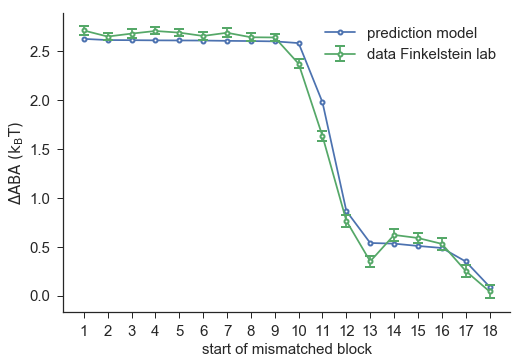

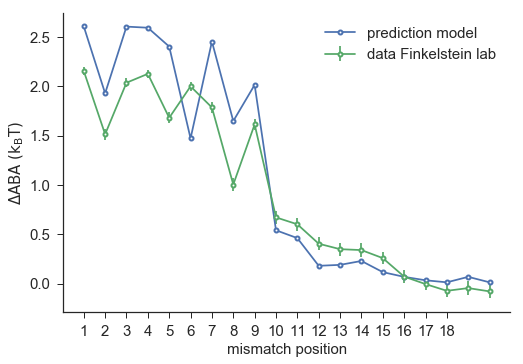

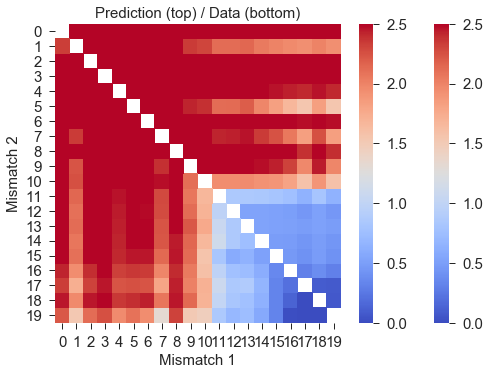

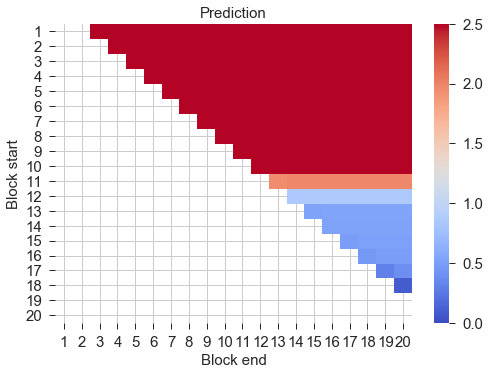

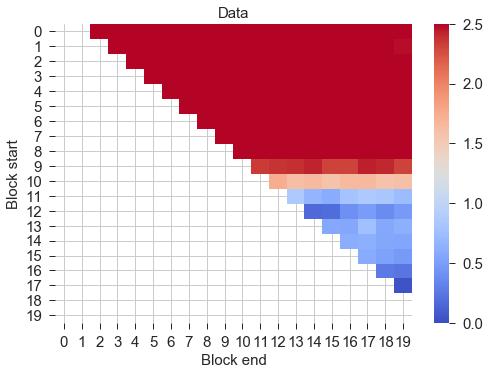

In [5]:
plt.figure()
_ = pltABA.predict_1D_mmblocks(boyle_params, model_id, T=60*10,guide_length=20);
plt.savefig('../reports/fig9_15_11_2018.pdf', format='pdf',bbox_inches='tight')



plt.figure()
_ = pltABA.predict_single_mm(boyle_params,model_id)
plt.savefig('../reports/fig10_15_11_2018.pdf', format='pdf',bbox_inches='tight')


plt.figure()
_ = pltABA.predict_double_mm(boyle_params,model_id)
plt.savefig('../reports/fig11_15_11_2018.pdf', format='pdf',bbox_inches='tight')


plt.figure()
_ = pltABA.predict_block_mismatches(parameters=boyle_params, model_id=model_id, T=60*10,guide_length=20)
